<a href="https://colab.research.google.com/github/solayman-cs/WindTurbine/blob/main/WindTurbine_ANalySis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
%cd /content/drive/My Drive/NoteBooks/Unet-Dr_Rahman

/content/drive/My Drive/NoteBooks/Unet-Dr_Rahman


In [76]:
#import all the libraries
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import os
import glob
import skimage.io as io
from PIL import Image
from skimage.viewer import ImageViewer
import matplotlib.pyplot as plt
from model import *

In [77]:
def trainGenerator(image_path,mask_path,flag_multi_class = False,num_class = 2,image_prefix = "image",mask_prefix = "mask",image_as_gray = True,mask_as_gray = True):
    image_name_arr = glob.glob(os.path.join(image_path,"*.png"))
    mask_name_arr = glob.glob(os.path.join(mask_path, "*.png"))
    image_arr = []
    mask_arr = []
    for index,item in enumerate(image_name_arr):
        img = io.imread(item,as_gray = image_as_gray)
        img = np.reshape(img,img.shape + (1,)) if image_as_gray else img
        img = img / 255
        image_arr.append(img)

    for index, item in enumerate(mask_name_arr):
        mask = io.imread(item, as_gray = image_as_gray)
        mask = np.reshape(mask,mask.shape + (1,)) if mask_as_gray else mask
        mask = mask/255
        mask[mask>0.5] = 1
        mask[mask<=0.5] = 0
        mask_arr.append(mask)

    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr,mask_arr

In [78]:
def testGenerator(test_path, image_num):
    for i in range(image_num):
        #idx = str(i+69).zfill(5) + ".png"
        idx = 'rgb_'+ str(i+70) + ".png"
        img = io.imread(os.path.join(test_path, idx), as_gray=True)
        img = img / 255
        img = np.reshape(img, img.shape + (1,))
        img = np.reshape(img,(1,)+img.shape)
        yield img

In [79]:
def testMask(test_path, image_num):
    Y_test = np.zeros((image_num, 512, 512, 1), dtype=np.bool)
    for i in range(image_num):
        #idx = str(i+69).zfill(5) + ".png"
        idx = 'segmentation_'+ str(i+70) + ".png"
        msk = io.imread(os.path.join(test_path, idx), as_gray=True)
        msk = msk / 255
        msk = np.reshape(msk, msk.shape + (1,))
        msk = np.reshape(msk,(1,)+msk.shape)
        Y_test[i] = msk
    return Y_test

In [80]:
def getItem(img_path, item):
    idx = str(item+1).zfill(5) + ".png"
    img = io.imread(os.path.join(img_path, idx), as_gray=True)
    img = img/255.0
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,)+img.shape)
    return img

In [81]:
def saveResult(save_path, files):
    for i, item in enumerate(files):
        img = item[:,:,0]
        idx = str(i+1).zfill(5) + ".png"
        io.imsave(os.path.join(save_path, idx), img)

In [82]:
def viewImage(array1, array2, i):
    img = np.reshape(array1[i], (512, 512))
    mask = np.reshape(array2[i], (512, 512))
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(img, cmap=plt.cm.gray)
    axarr[1].imshow(mask, cmap=plt.cm.gray)
    plt.show()

(639, 512, 512, 1)
(642, 512, 512, 1)


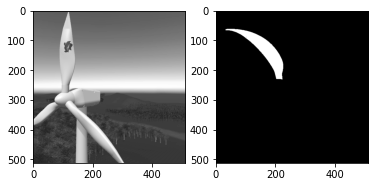

In [83]:
# Load the train data and their corresponding labels
# Visualize a sample image
imgs_train,imgs_mask_train= trainGenerator("train/images/","train/masks/")
print(imgs_train.shape)   
print(imgs_mask_train.shape)
index = np.random.randint(1, 50)
viewImage(imgs_train, imgs_mask_train, index)

In [71]:
!pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 7.6 MB/s eta 0:00:00


In [84]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from segmentation_models import Unet, FPN
from segmentation_models import  get_preprocessing # this line has an error in the docs

from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from segmentation_models.losses import dice_loss
#from segmentation_models.metrics import dice_score

from segmentation_models.utils import set_trainable

In [13]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [14]:
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [15]:
from keras import backend as K
def jaccard_loss(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [85]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

def unet(input_size = (512, 512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = [dice_loss], metrics = [iou_score])

    return model



In [86]:
# laod model and show the model summary
model = unet()
model_checkpoint = ModelCheckpoint('windTurbine_segmentation.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 512, 512, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_25 (Conv2D)             (None, 512, 512, 64  36928       ['conv2d_24[0][0]']              
                                )                                                           

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [89]:
# train the model
hm_epochs = 100
batch_size = 4
model.fit(imgs_train, imgs_mask_train, batch_size=batch_size, epochs=hm_epochs, verbose=1,
          validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

Epoch 1/100
128/128 [==============================] - ETA: 0s - loss: 0.9931 - iou_score: 0.0035
Epoch 1: loss improved from inf to 0.99308, saving model to windTurbine_segmentation.hdf5
128/128 [==============================] - 184s 1s/step - loss: 0.9931 - iou_score: 0.0035 - val_loss: 0.9928 - val_iou_score: 0.0036
Epoch 2/100
128/128 [==============================] - ETA: 0s - loss: 0.9928 - iou_score: 0.0036
Epoch 2: loss improved from 0.99308 to 0.99282, saving model to windTurbine_segmentation.hdf5
128/128 [==============================] - 175s 1s/step - loss: 0.9928 - iou_score: 0.0036 - val_loss: 0.9921 - val_iou_score: 0.0040
Epoch 3/100
128/128 [==============================] - ETA: 0s - loss: 0.9944 - iou_score: 0.0028
Epoch 3: loss did not improve from 0.99282
128/128 [==============================] - 170s 1s/step - loss: 0.9944 - iou_score: 0.0028 - val_loss: 1.0000 - val_iou_score: 1.1860e-07
Epoch 4/100
128/128 [==============================] - ETA: 0s - loss: 0.

KeyboardInterrupt: ignored

In [90]:
test_path = 'test/images/'
test_image_arr = glob.glob(os.path.join(test_path, "*.png"))
num_of_test_images = len(test_image_arr)

testGene = testGenerator(test_path, num_of_test_images)

results = model.predict(testGene, num_of_test_images, verbose=1)

# print(results)

2/2 [==============================] - 1s 280ms/step


In [91]:
print(results[0])

[[[0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]
  ...
  [0.0000000e+00]
  [0.0000000e+00]
  [2.9631655e-22]]

 [[0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]
  ...
  [0.0000000e+00]
  [0.0000000e+00]
  [1.5667702e-38]]

 [[0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]
  ...
  [0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]]

 ...

 [[0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]
  ...
  [0.0000000e+00]
  [0.0000000e+00]
  [4.0183226e-24]]

 [[0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]
  ...
  [0.0000000e+00]
  [2.6022886e-28]
  [8.8481985e-15]]

 [[0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]
  ...
  [3.6554747e-16]
  [3.9949283e-10]
  [3.4252971e-05]]]


In [92]:
results = results >= 0.1

In [93]:
print(results)

[[[[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  ...

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]]


 [[[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  ...

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]]]


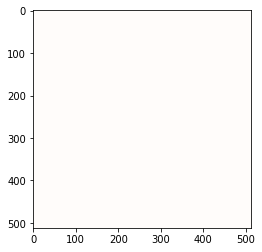

In [94]:
#plt.imshow(results[0], cmap='Reds', alpha=0.3)
plt.imshow(np.squeeze(results[0]), cmap='Reds', alpha=0.3)

In [95]:
test_path = 'test/masks/'
test_image_arr = glob.glob(os.path.join(test_path, "*.png"))
num_of_test_images = len(test_image_arr)

testMsk = testMask(test_path, num_of_test_images)

<ipython-input-79-edfec19f9dbc>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_test = np.zeros((image_num, 512, 512, 1), dtype=np.bool)


In [96]:
print(testMsk[0])

[[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]]


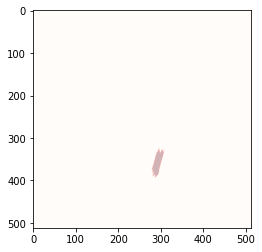

In [97]:
plt.imshow(np.squeeze(testMsk[1]), cmap='Reds', alpha=0.3)

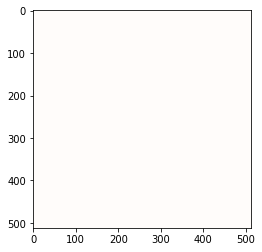

In [98]:
plt.imshow(np.squeeze(results[1]), cmap='Reds', alpha=0.3)

In [99]:
idx = 0
true = testMsk[idx]
predicted = results[idx]

In [100]:
intersection = np.logical_and(predicted, true)
union = np.logical_or(predicted, true)
iou_score = np.sum(intersection) / np.sum(union)
print('IoU is %s' % iou_score)

IoU is 0.0


In [101]:
def Jaccard_img(y_true, y_pred): #https://www.jeremyjordan.me/evaluating-image-segmentation-models/
    iou_score=0
    counter=0
    for i in range(y_true.shape[0]):
        if np.sum(y_true[i])>0:#Considering only the slices that have hemorrhage regions, if y_true is all zeros -> iou_score=nan.
            im1 = np.asarray(y_true[i]).astype(np.bool)
            im2 = np.asarray(y_pred[i]).astype(np.bool)
            intersection = np.logical_and(im1, im2)
            union = np.logical_or(im1, im2)
            iou_score+= np.sum(intersection) / np.sum(union)
            counter+=1
    if counter>0:
        return iou_score/counter
    else:
        return np.nan

In [102]:
jac_indx = Jaccard_img(predicted, true)
print(jac_indx)
print('*_--------------------------------------------')

nan
*_--------------------------------------------
